##### IMPORTS

In [98]:
import re
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from pathlib import Path

# Display
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [99]:
from tensorflow import keras as tfk
from tensorflow.keras import layers

print(tf.__version__)
print(tfk.models.load_model)

2.13.0
<function load_model at 0x000001FCC0C1A3B0>


##### DEFINITIONS

In [100]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = tfk.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = tfk.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array

##### ROOT

In [101]:
root = Path.cwd()

##### EXAMPLE IMAGE

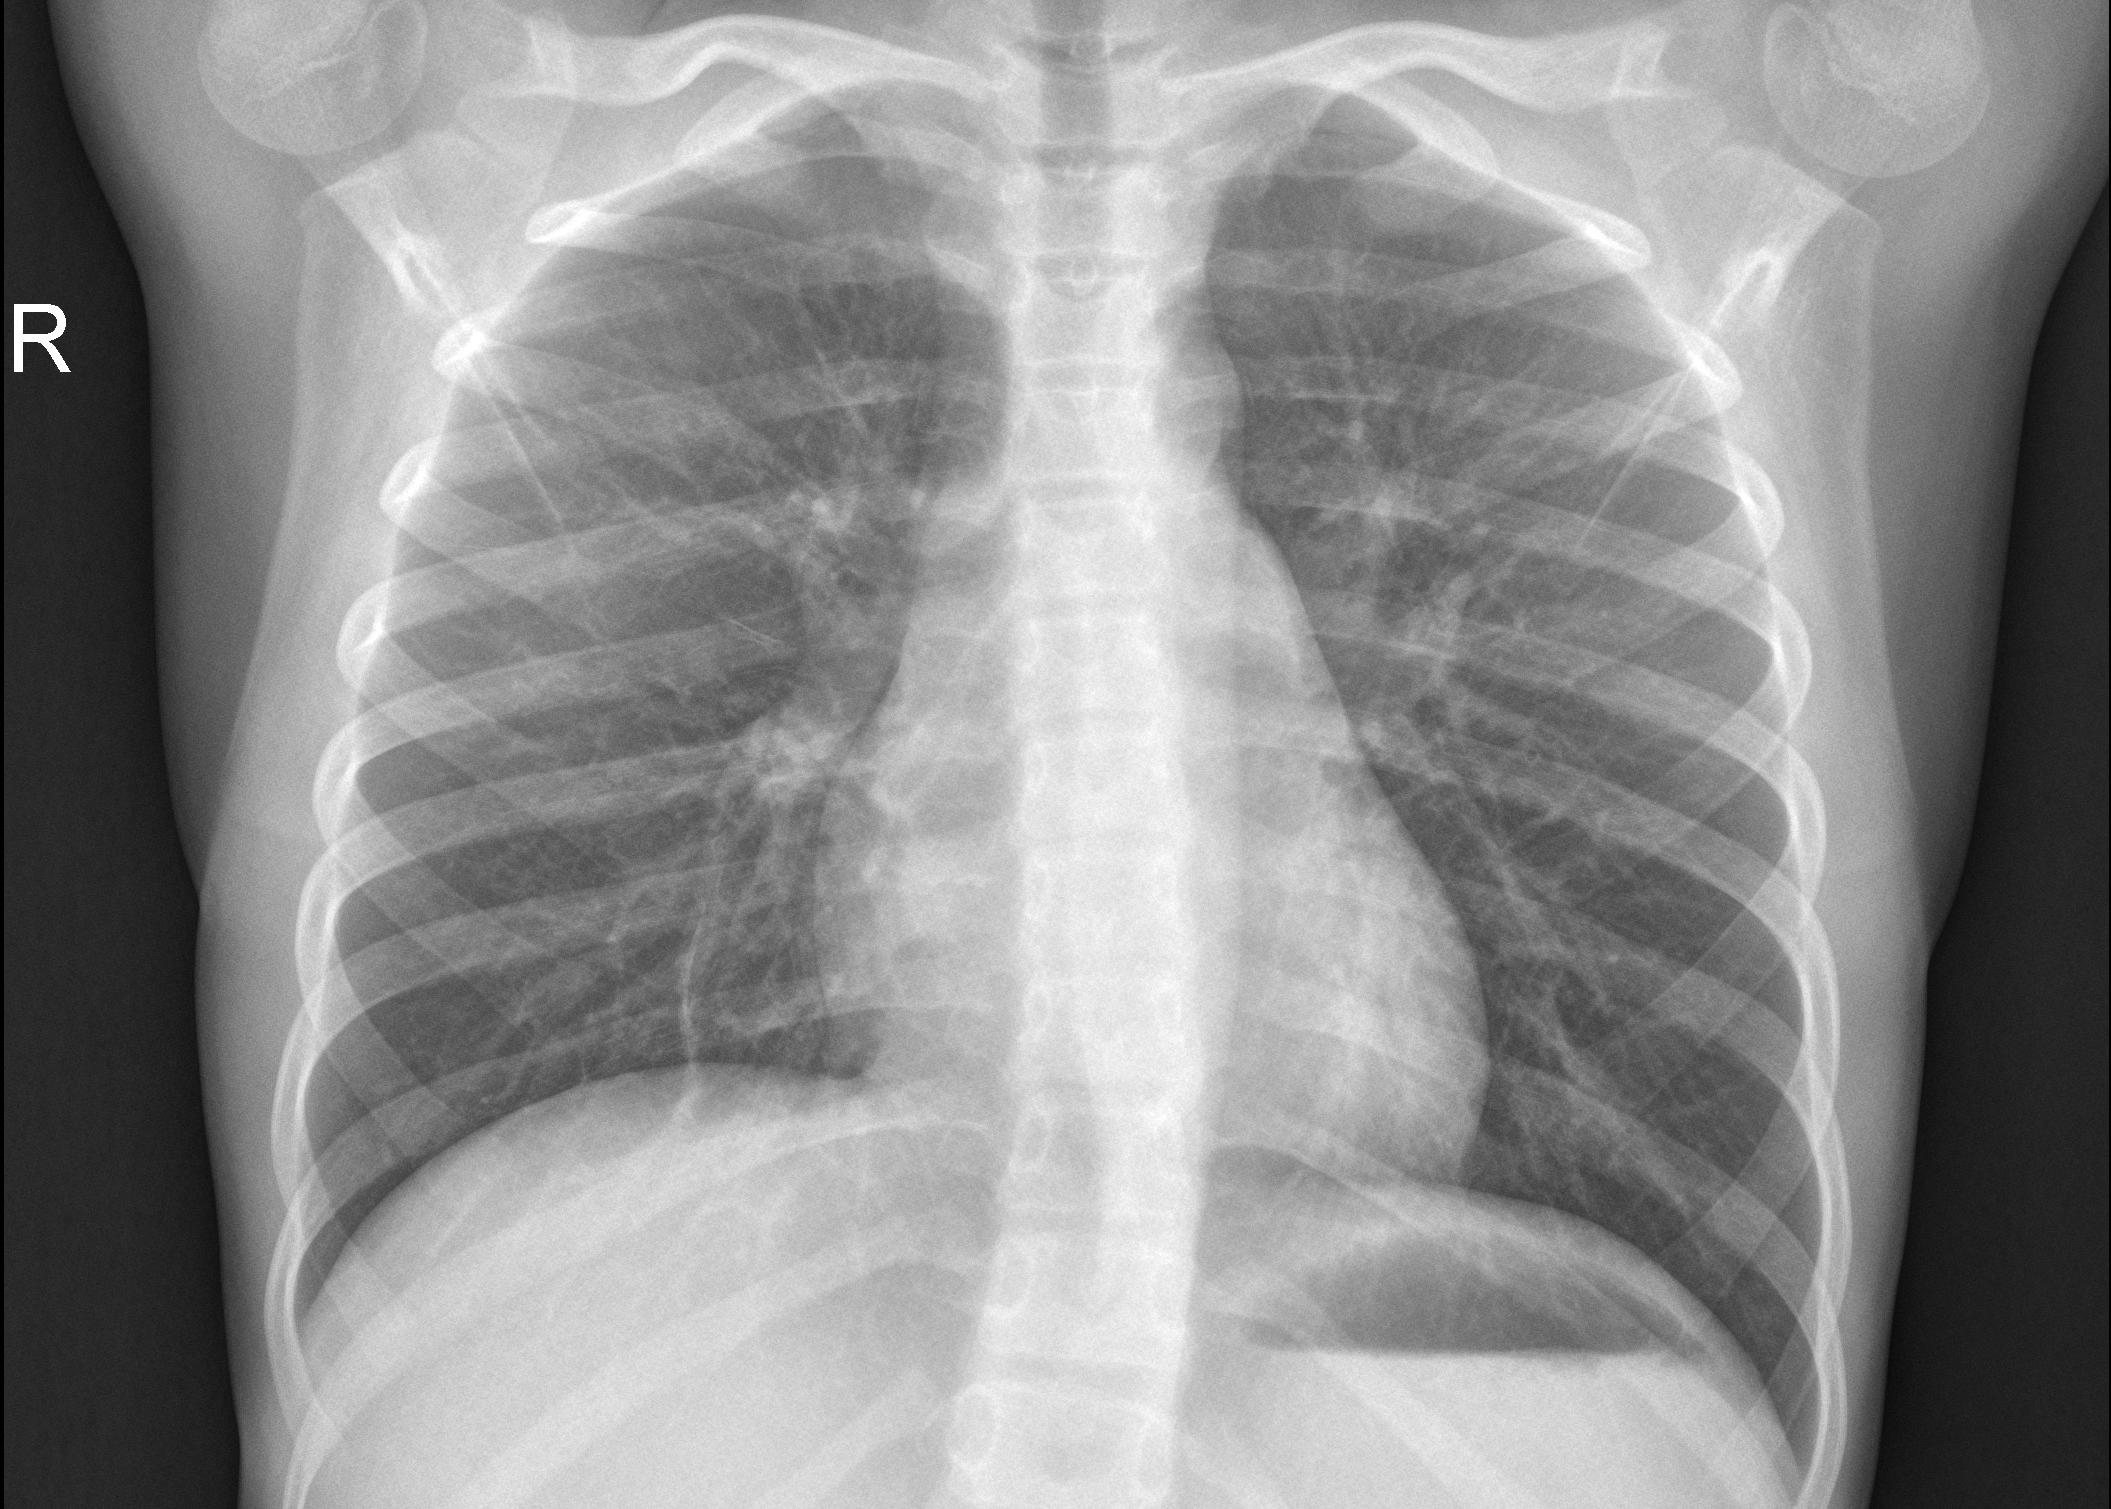

In [102]:
# The local path to our target image
img_size = (299, 299)

img_path = root / "../data/data_sample/chest_xray/NORMAL/IM-0003-0001.jpeg"
display(Image(img_path))

##### PREPARE IMAGE

In [103]:
last_conv_layer_name = "block14_sepconv2_act"

In [104]:
# Prepare image
img_array = preprocess_input(get_img_array(img_path, size=img_size))
img_array = get_img_array(img_path, size=img_size)

##### LOAD MODEL

In [105]:
model_builder = tfk.applications.xception.Xception
preprocess_input = tfk.applications.xception.preprocess_input
decode_predictions = tfk.applications.xception.decode_predictions

In [106]:
# Make model
model = model_builder(weights="imagenet")

model.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 149, 149, 32)         864       ['input_5[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 149, 149, 32)         128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activati  (None, 149, 149, 32)         0         ['block1_conv1_bn[0][0]

In [107]:
last_conv_layer_name = "block14_sepconv2_act"

In [108]:
# Remove last layer's softmax
model.layers[-1].activation = None

In [109]:
# Print what the top predicted class is
preds = model.predict(img_array)
print(preds)

1/1 [==============================] - 2s 2s/step
[[ 6.86304321e+01  5.34103012e+01 -3.16740341e+01 -6.42659836e+01
  -8.26176071e+01 -9.16261368e+01 -2.95180073e+01 -1.85000839e+01
   1.23954983e+01 -1.49994659e+01  7.17624893e+01  2.57364807e+01
   4.33367577e+01 -3.72260666e+01 -1.89633884e+01 -1.70913467e+02
   3.65922890e+01  1.91283131e+01 -2.83790779e+01 -2.54096775e+01
  -3.21274796e+01 -5.85161896e+01 -6.91816025e+01 -7.48624344e+01
  -2.42457390e+01 -7.28626938e+01  4.00449944e+01  2.65045238e+00
  -4.39375925e+00 -3.72395096e+01  9.34351730e+00  7.98564453e+01
   5.20091820e+01  4.62923737e+01  9.28670654e+01  2.99509201e+01
   3.71381416e+01 -2.63234043e+01 -6.05114603e+00  3.57313347e+01
   8.80596085e+01 -6.09048414e+00  1.31918025e+00 -6.99125290e+01
  -4.78474274e+01 -6.14457207e+01  8.49470978e+01  4.10272369e+01
   3.10665646e+01 -2.29133415e+01  6.37147827e+01  8.74874344e+01
  -3.28125610e+01 -6.33059616e+01 -1.15427742e+01 -7.12825317e+01
  -7.71278000e+01 -9.30691

##### GRADCAM

In [110]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tfk.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

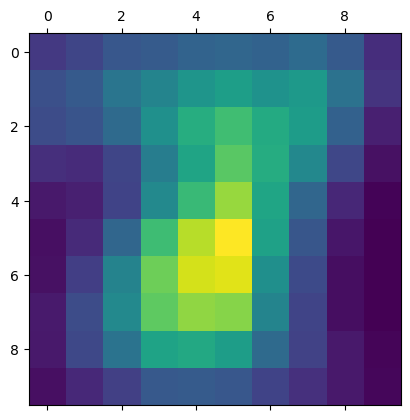

In [111]:
# Display heatmap
plt.matshow(heatmap)
plt.show()

In [112]:
def save_and_display_gradcam(img_path, heatmap, ax, out_path, alpha=0.4):
    # Load the original image
    img = tfk.preprocessing.image.load_img(img_path)
    img = tfk.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tfk.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tfk.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tfk.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(out_path)

    # Display Grad CAM
    display(Image(out_path))

    plt.imshow(superimposed_img)

C:\Users\Giacomo Da Re\AppData\Local\Temp\ipykernel_32280\3427993503.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  jet = cm.get_cmap("jet")


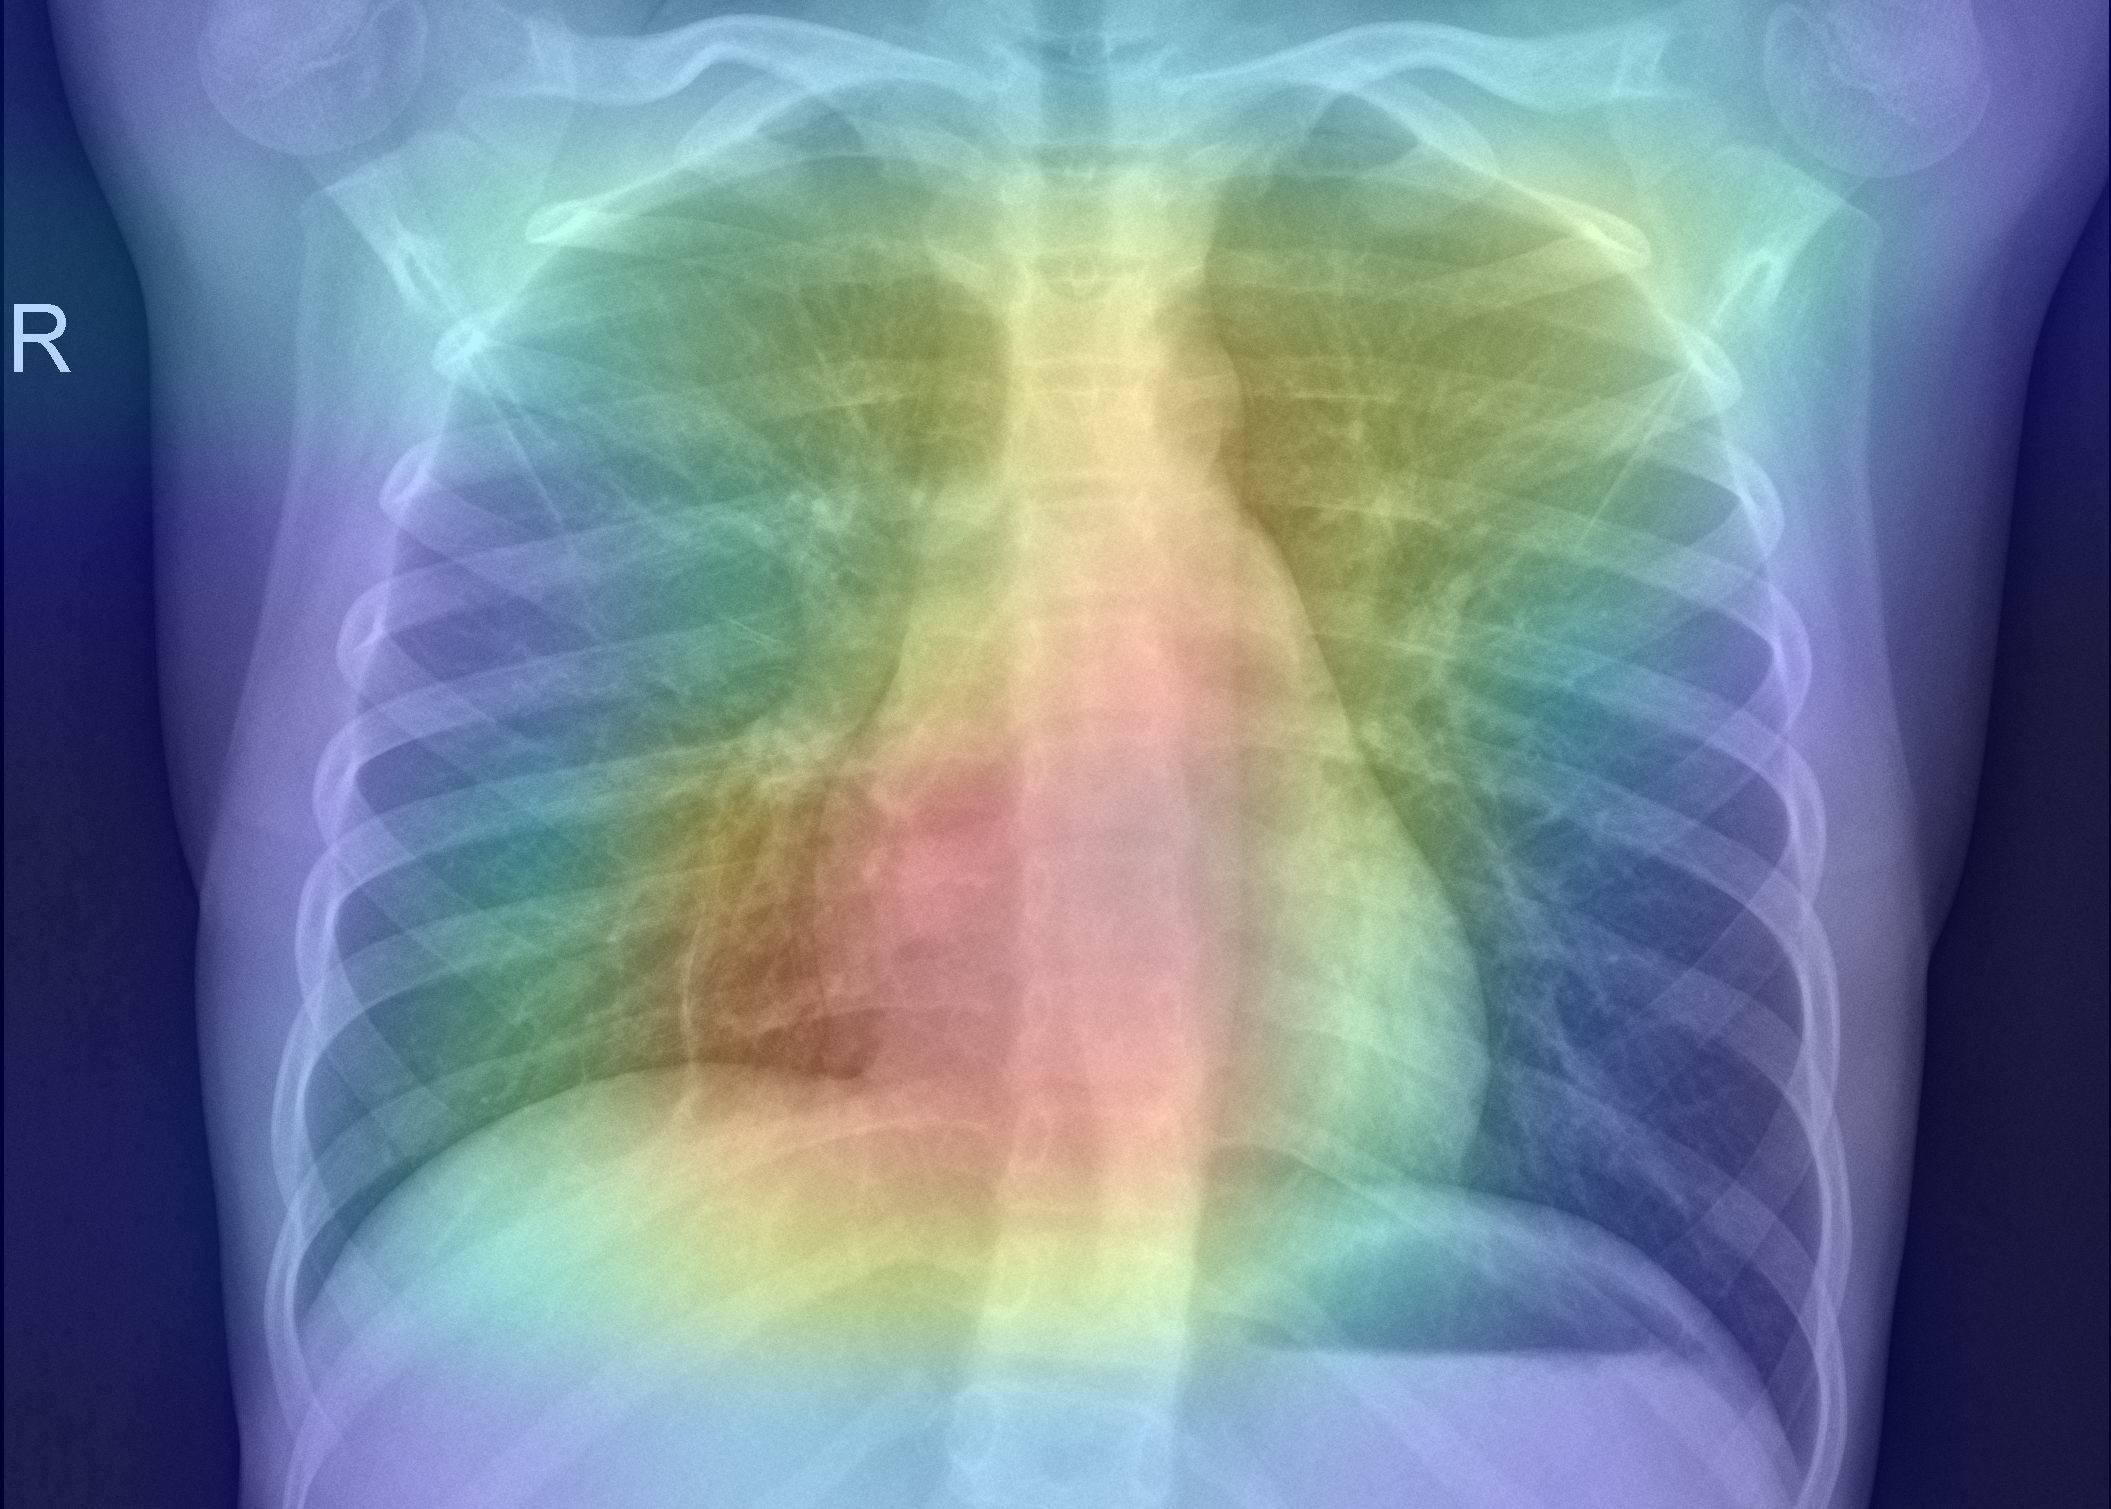

In [113]:
save_and_display_gradcam(img_path, heatmap, None, "../output/gradcam/xception_model/cam_ex.jpeg")

##### GENERATE AND SAVE PRINTS

In [114]:
N_images_paths = os.listdir('../data/data_sample/chest_xray/NORMAL')
P_images_paths = os.listdir('../data/data_sample/chest_xray/PNEUMONIA')

In [115]:
print(np.random.choice(N_images_paths, 3))

['IM-0031-0001.jpeg' 'IM-0005-0001.jpeg' 'IM-0021-0001.jpeg']


In [116]:
len(N_images_paths), len(P_images_paths)

(44, 44)

In [117]:
# Choose a number of images to show for each group
num_of_images_per_group = 3

In [118]:
# Get random images
random_N_images = np.random.choice(N_images_paths, num_of_images_per_group)
random_N_images = [path for path in random_N_images]
random_P_images = np.random.choice(P_images_paths, num_of_images_per_group)
random_P_images = [path for path in random_P_images]

In [119]:
# Concatenate them to get a unique list
images_path = np.concatenate((random_N_images, random_P_images))

In [120]:
def scan_label(label):

    if label == 'N':
        random_images = random_N_images
        data_folder_dir = '../data/data_sample/chest_xray/NORMAL/'
        dest_dir = "../output/gradcam/xception_model/NORMAL/"
    else:
        random_images = random_P_images
        data_folder_dir = '../data/data_sample/chest_xray/PNEUMONIA/'
        dest_dir = "../output/gradcam/xception_model/PNEUMONIA/"
        
    for i in range(0, num_of_images_per_group):
        img_path = data_folder_dir + random_images[i]
        img_dest_path = dest_dir + random_images[i]
        
        img = Image(img_path)
        display(img)
        img_array = get_img_array(img_path, size=img_size)
        heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
        save_and_display_gradcam(img_path, heatmap, None, img_dest_path)
        print()
        result = model.predict(img_array)
        print(img_path)
        print(img_dest_path)
        print(result)
        print('\n\n\n')

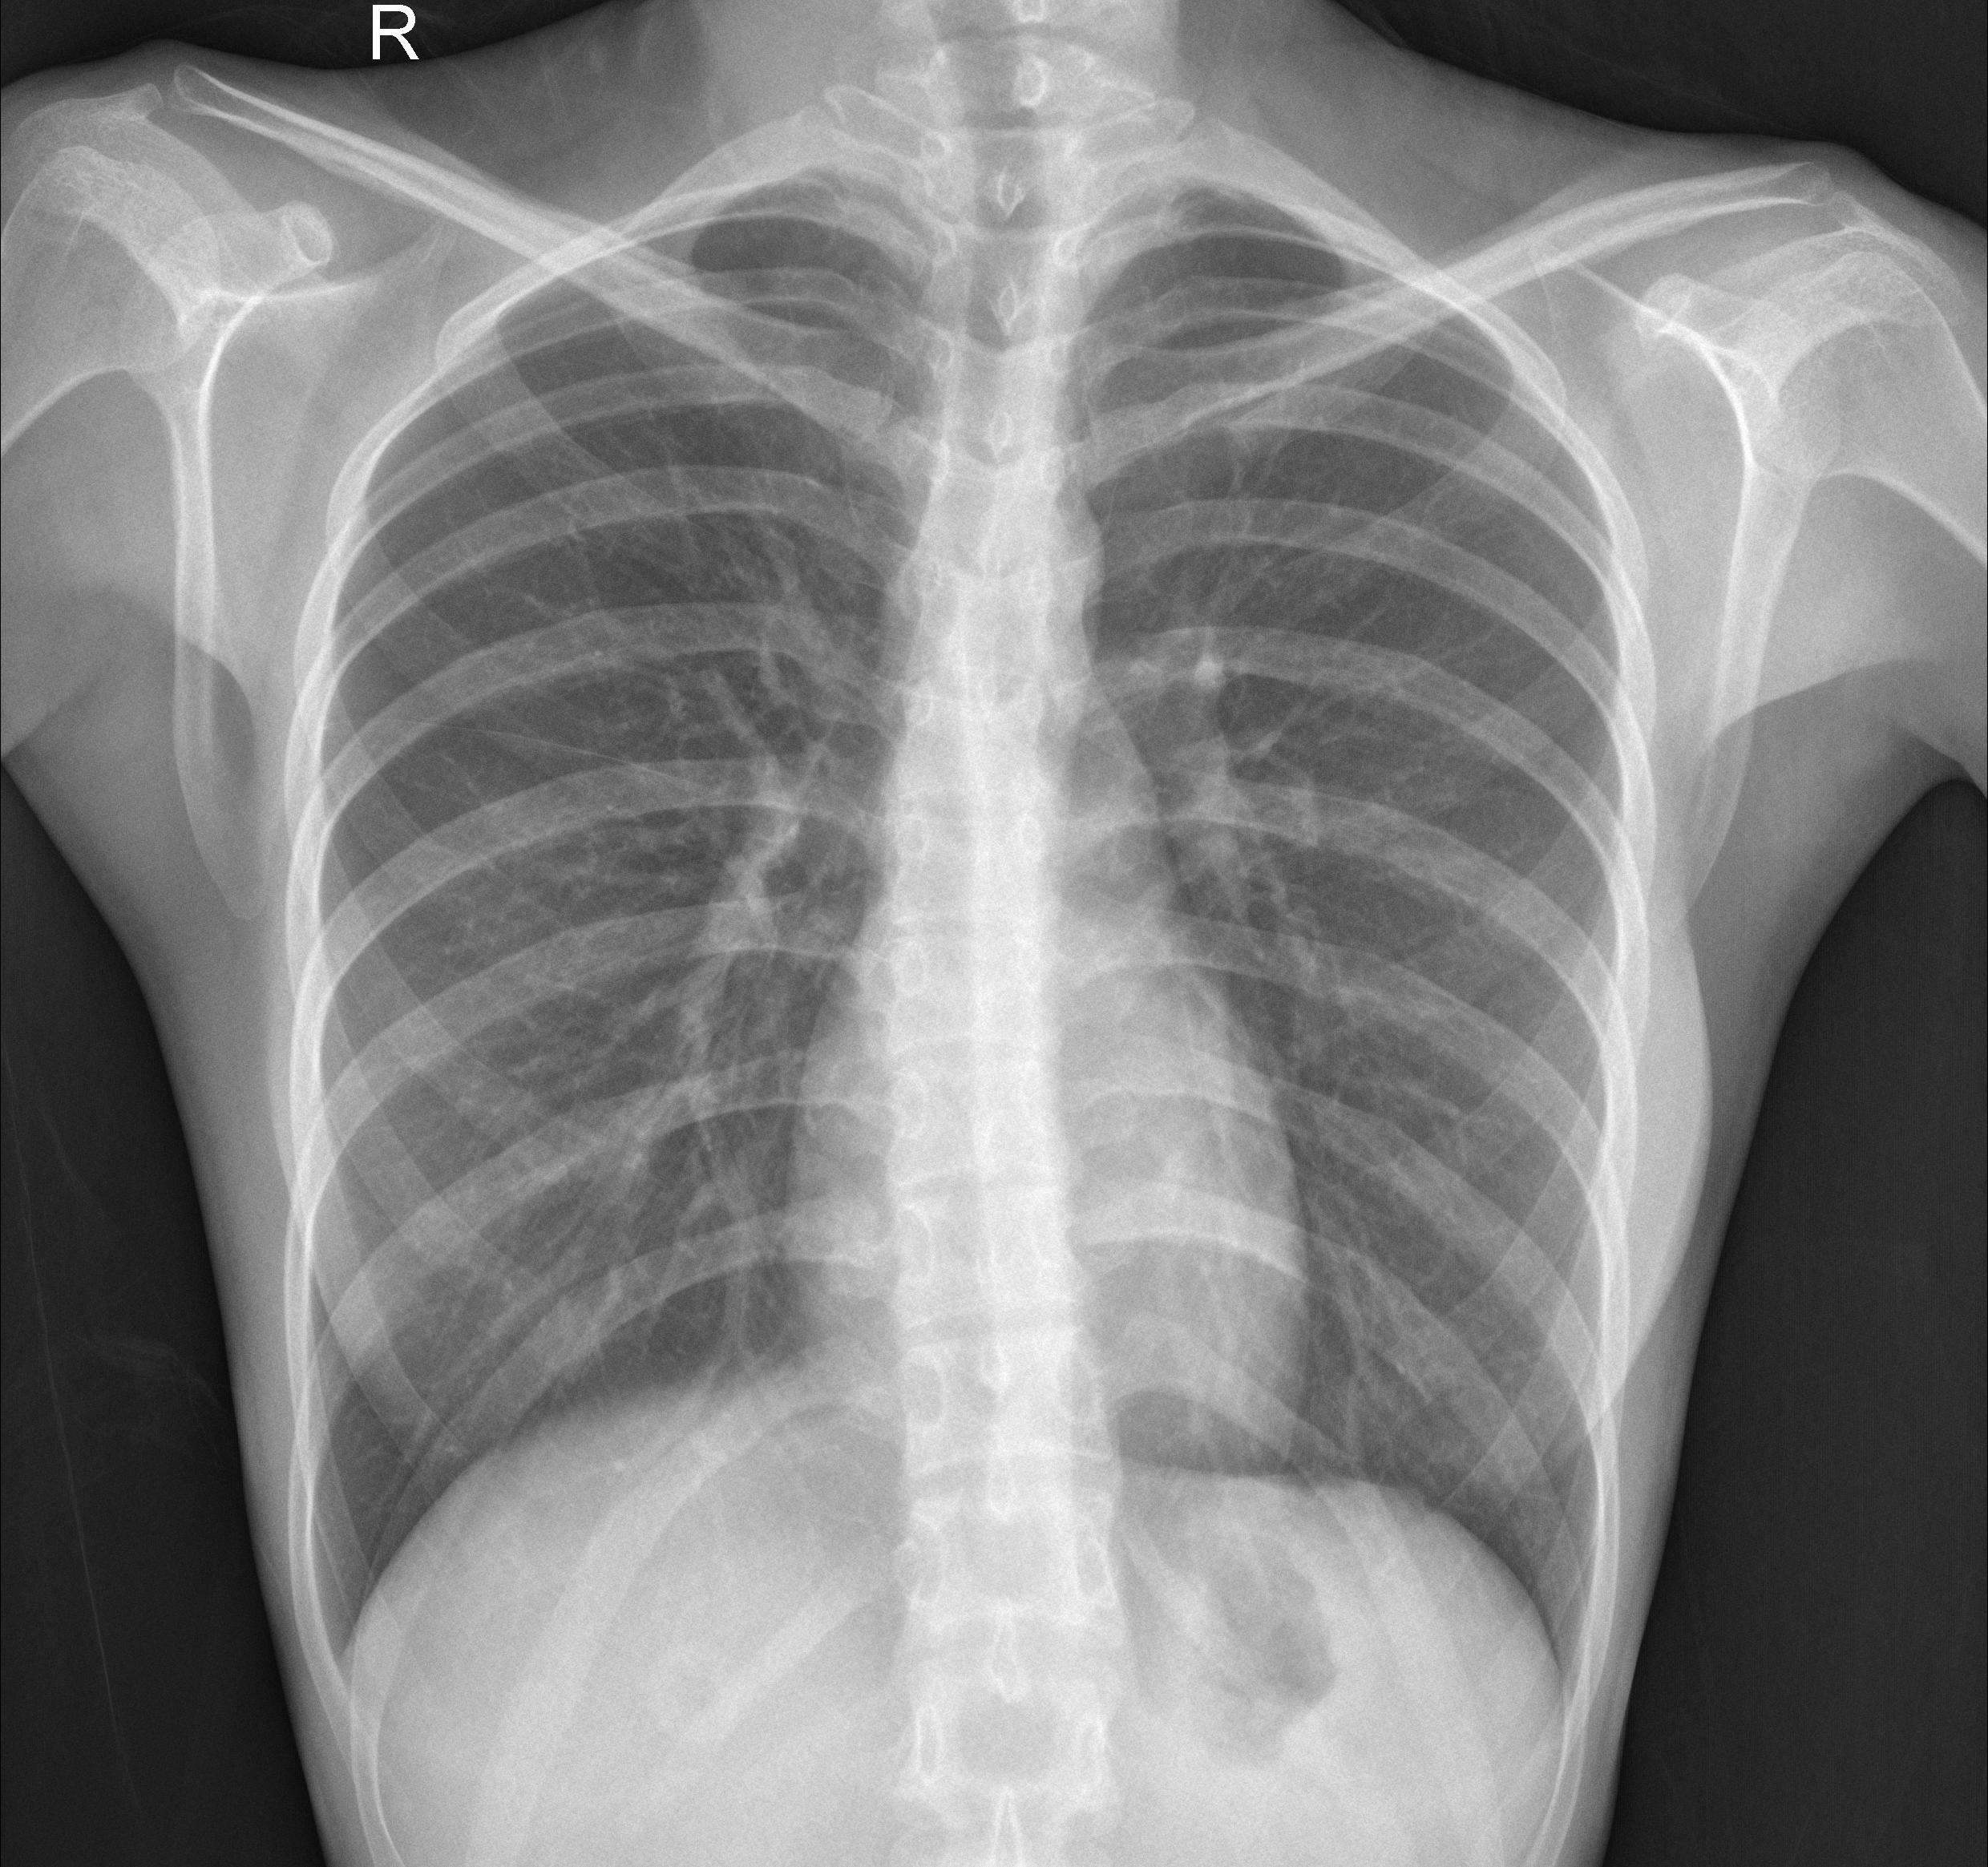

C:\Users\Giacomo Da Re\AppData\Local\Temp\ipykernel_32280\3427993503.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  jet = cm.get_cmap("jet")


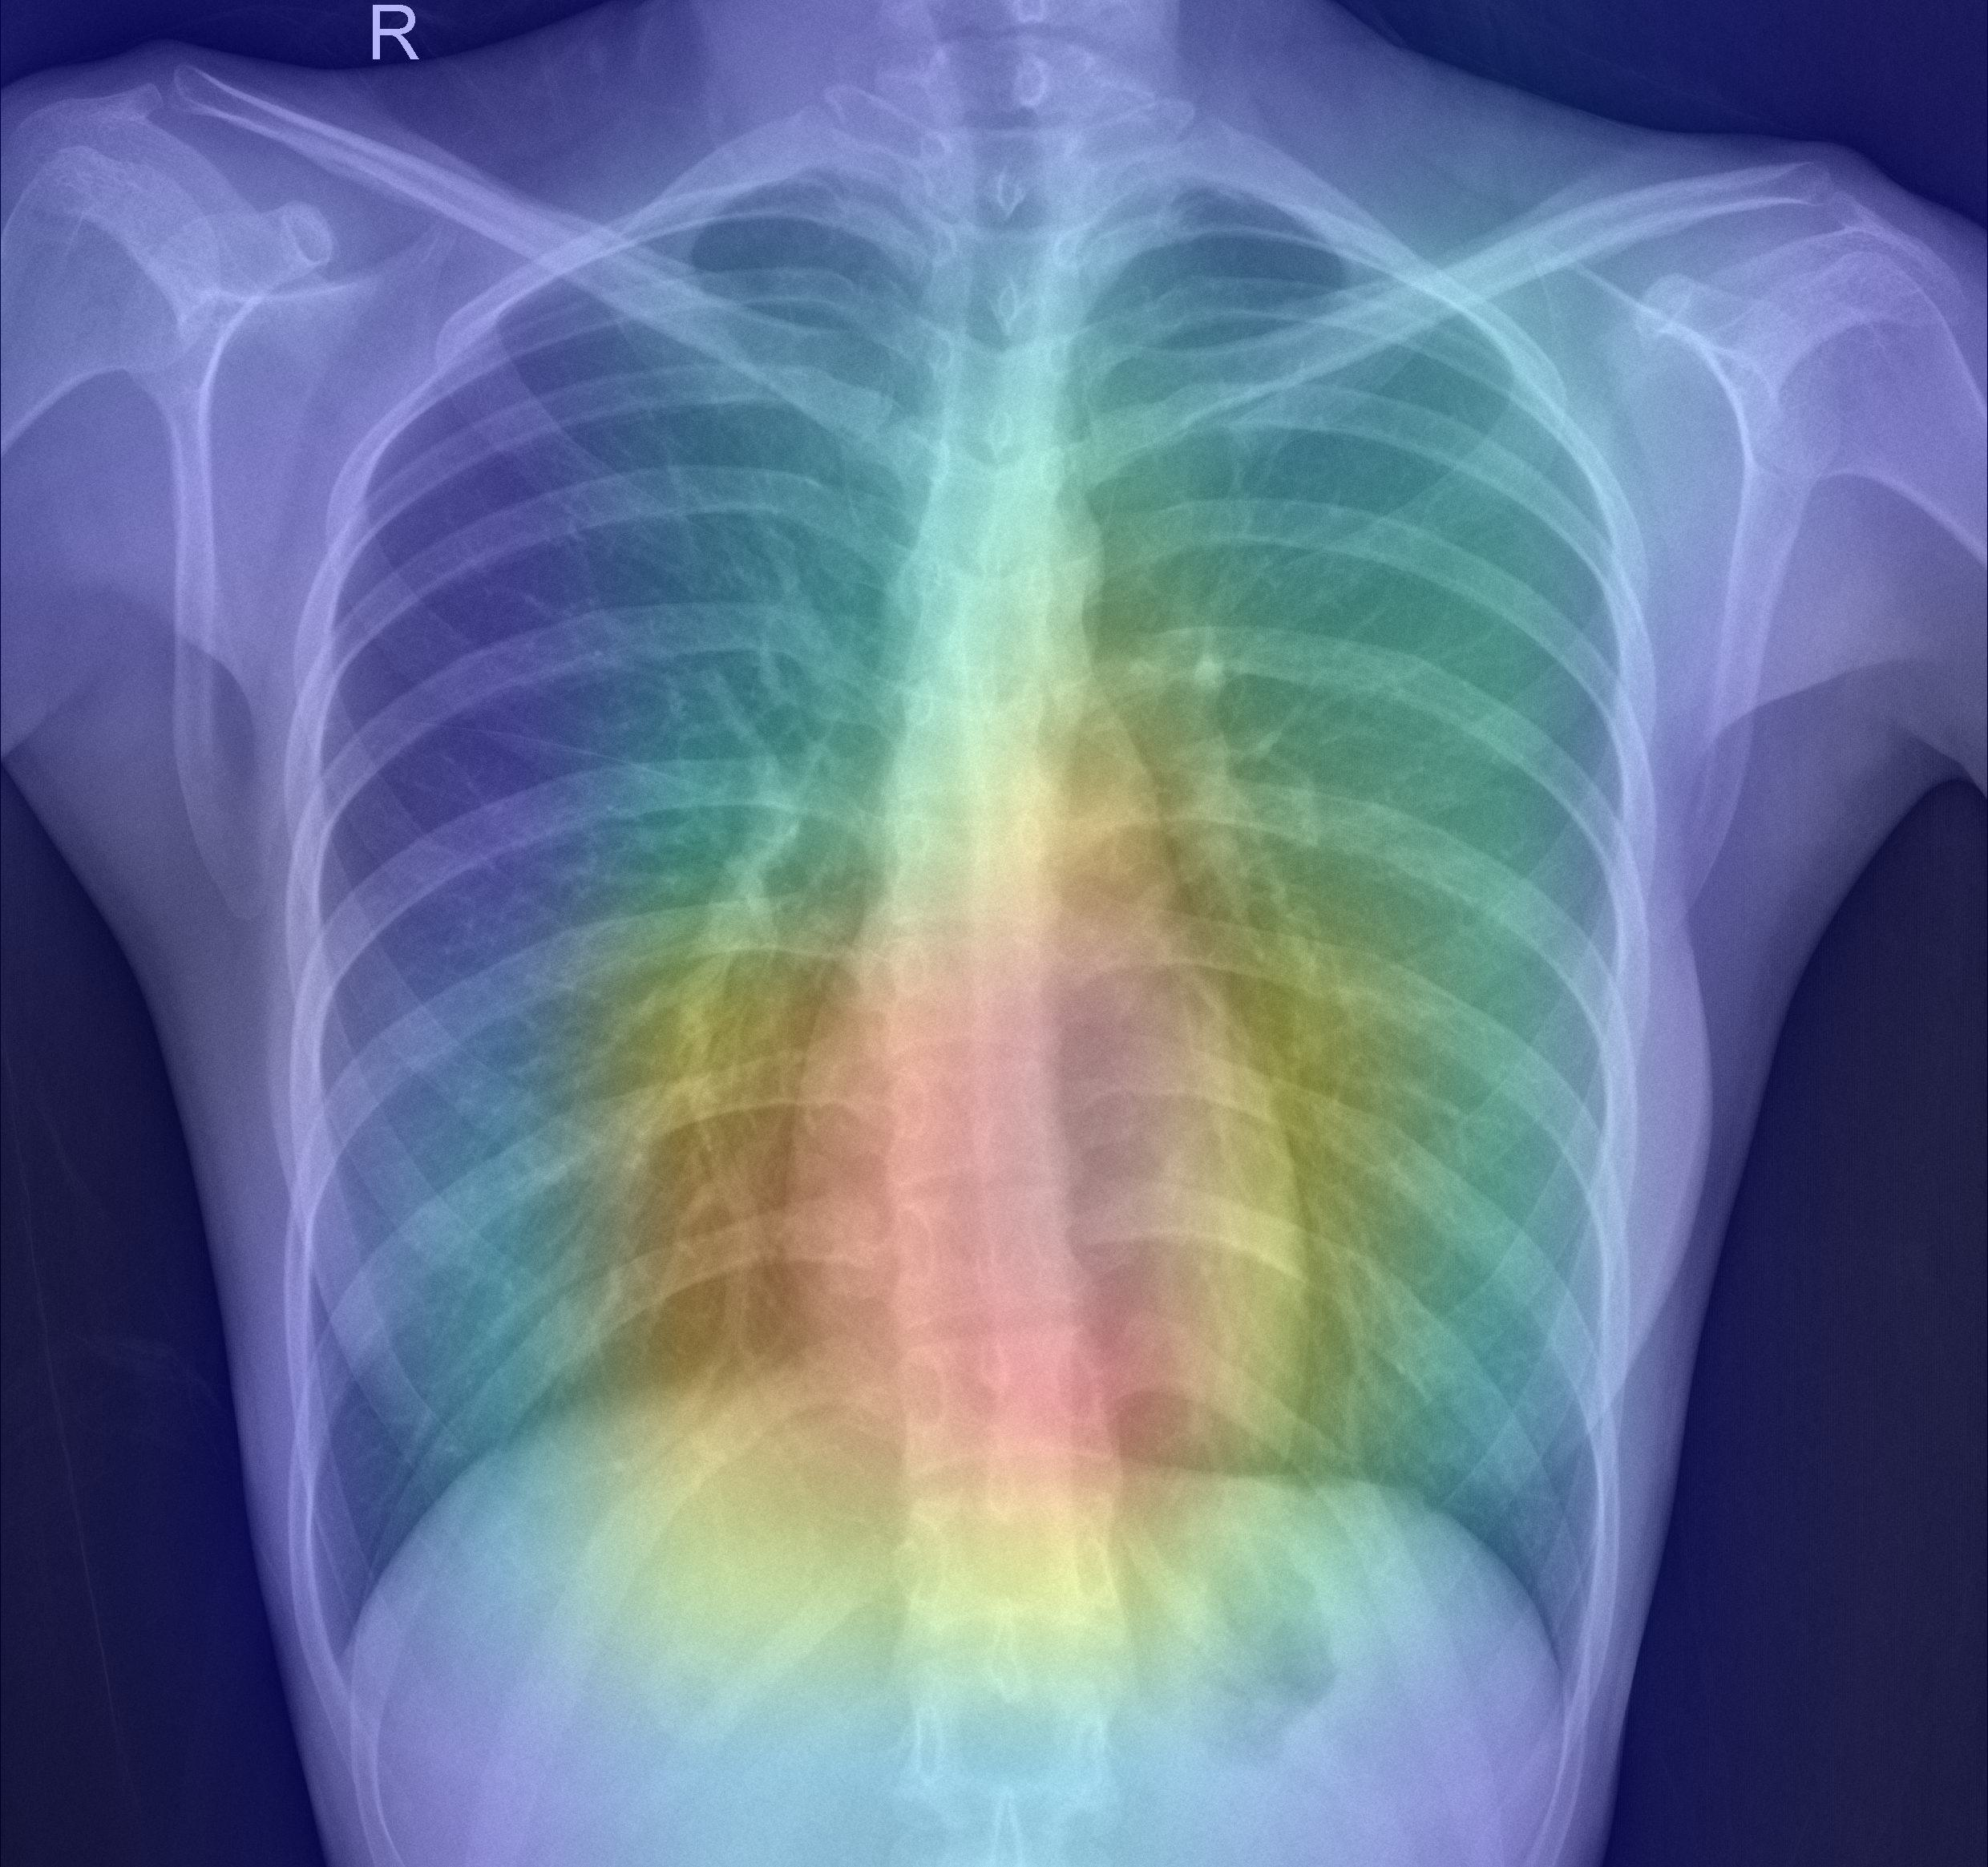


1/1 [==============================] - 0s 213ms/step
../data/data_sample/chest_xray/NORMAL/IM-0035-0001.jpeg
../output/gradcam/xception_model/NORMAL/IM-0035-0001.jpeg
[[ 4.24018936e+01  2.26118488e+01 -2.86197033e+01 -5.73293991e+01
  -4.46931648e+01 -6.54650116e+01 -1.52620115e+01 -1.40827408e+01
   1.63911104e-01 -7.55352449e+00  5.73879128e+01  1.99223061e+01
   2.65525227e+01 -3.51142960e+01 -1.76264877e+01 -1.31747772e+02
   4.00300026e+01  3.51716423e+01 -2.26065750e+01 -2.07695179e+01
  -1.86733513e+01 -4.17201958e+01 -5.45491180e+01 -5.84003143e+01
  -2.41981449e+01 -5.53572159e+01  2.27218838e+01  7.97768211e+00
  -6.26941872e+00 -3.13164730e+01  6.30463791e+00  5.74251099e+01
   3.82552299e+01  3.82231865e+01  6.90589447e+01  2.29331455e+01
   2.78079395e+01 -2.54227829e+01 -3.25588512e+00  1.55704432e+01
   5.44929695e+01  4.76594019e+00  8.10806847e+00 -6.31603127e+01
  -4.37330170e+01 -4.27191200e+01  5.70191536e+01  4.39744568e+01
   1.67819195e+01 -1.06619577e+01  5.305

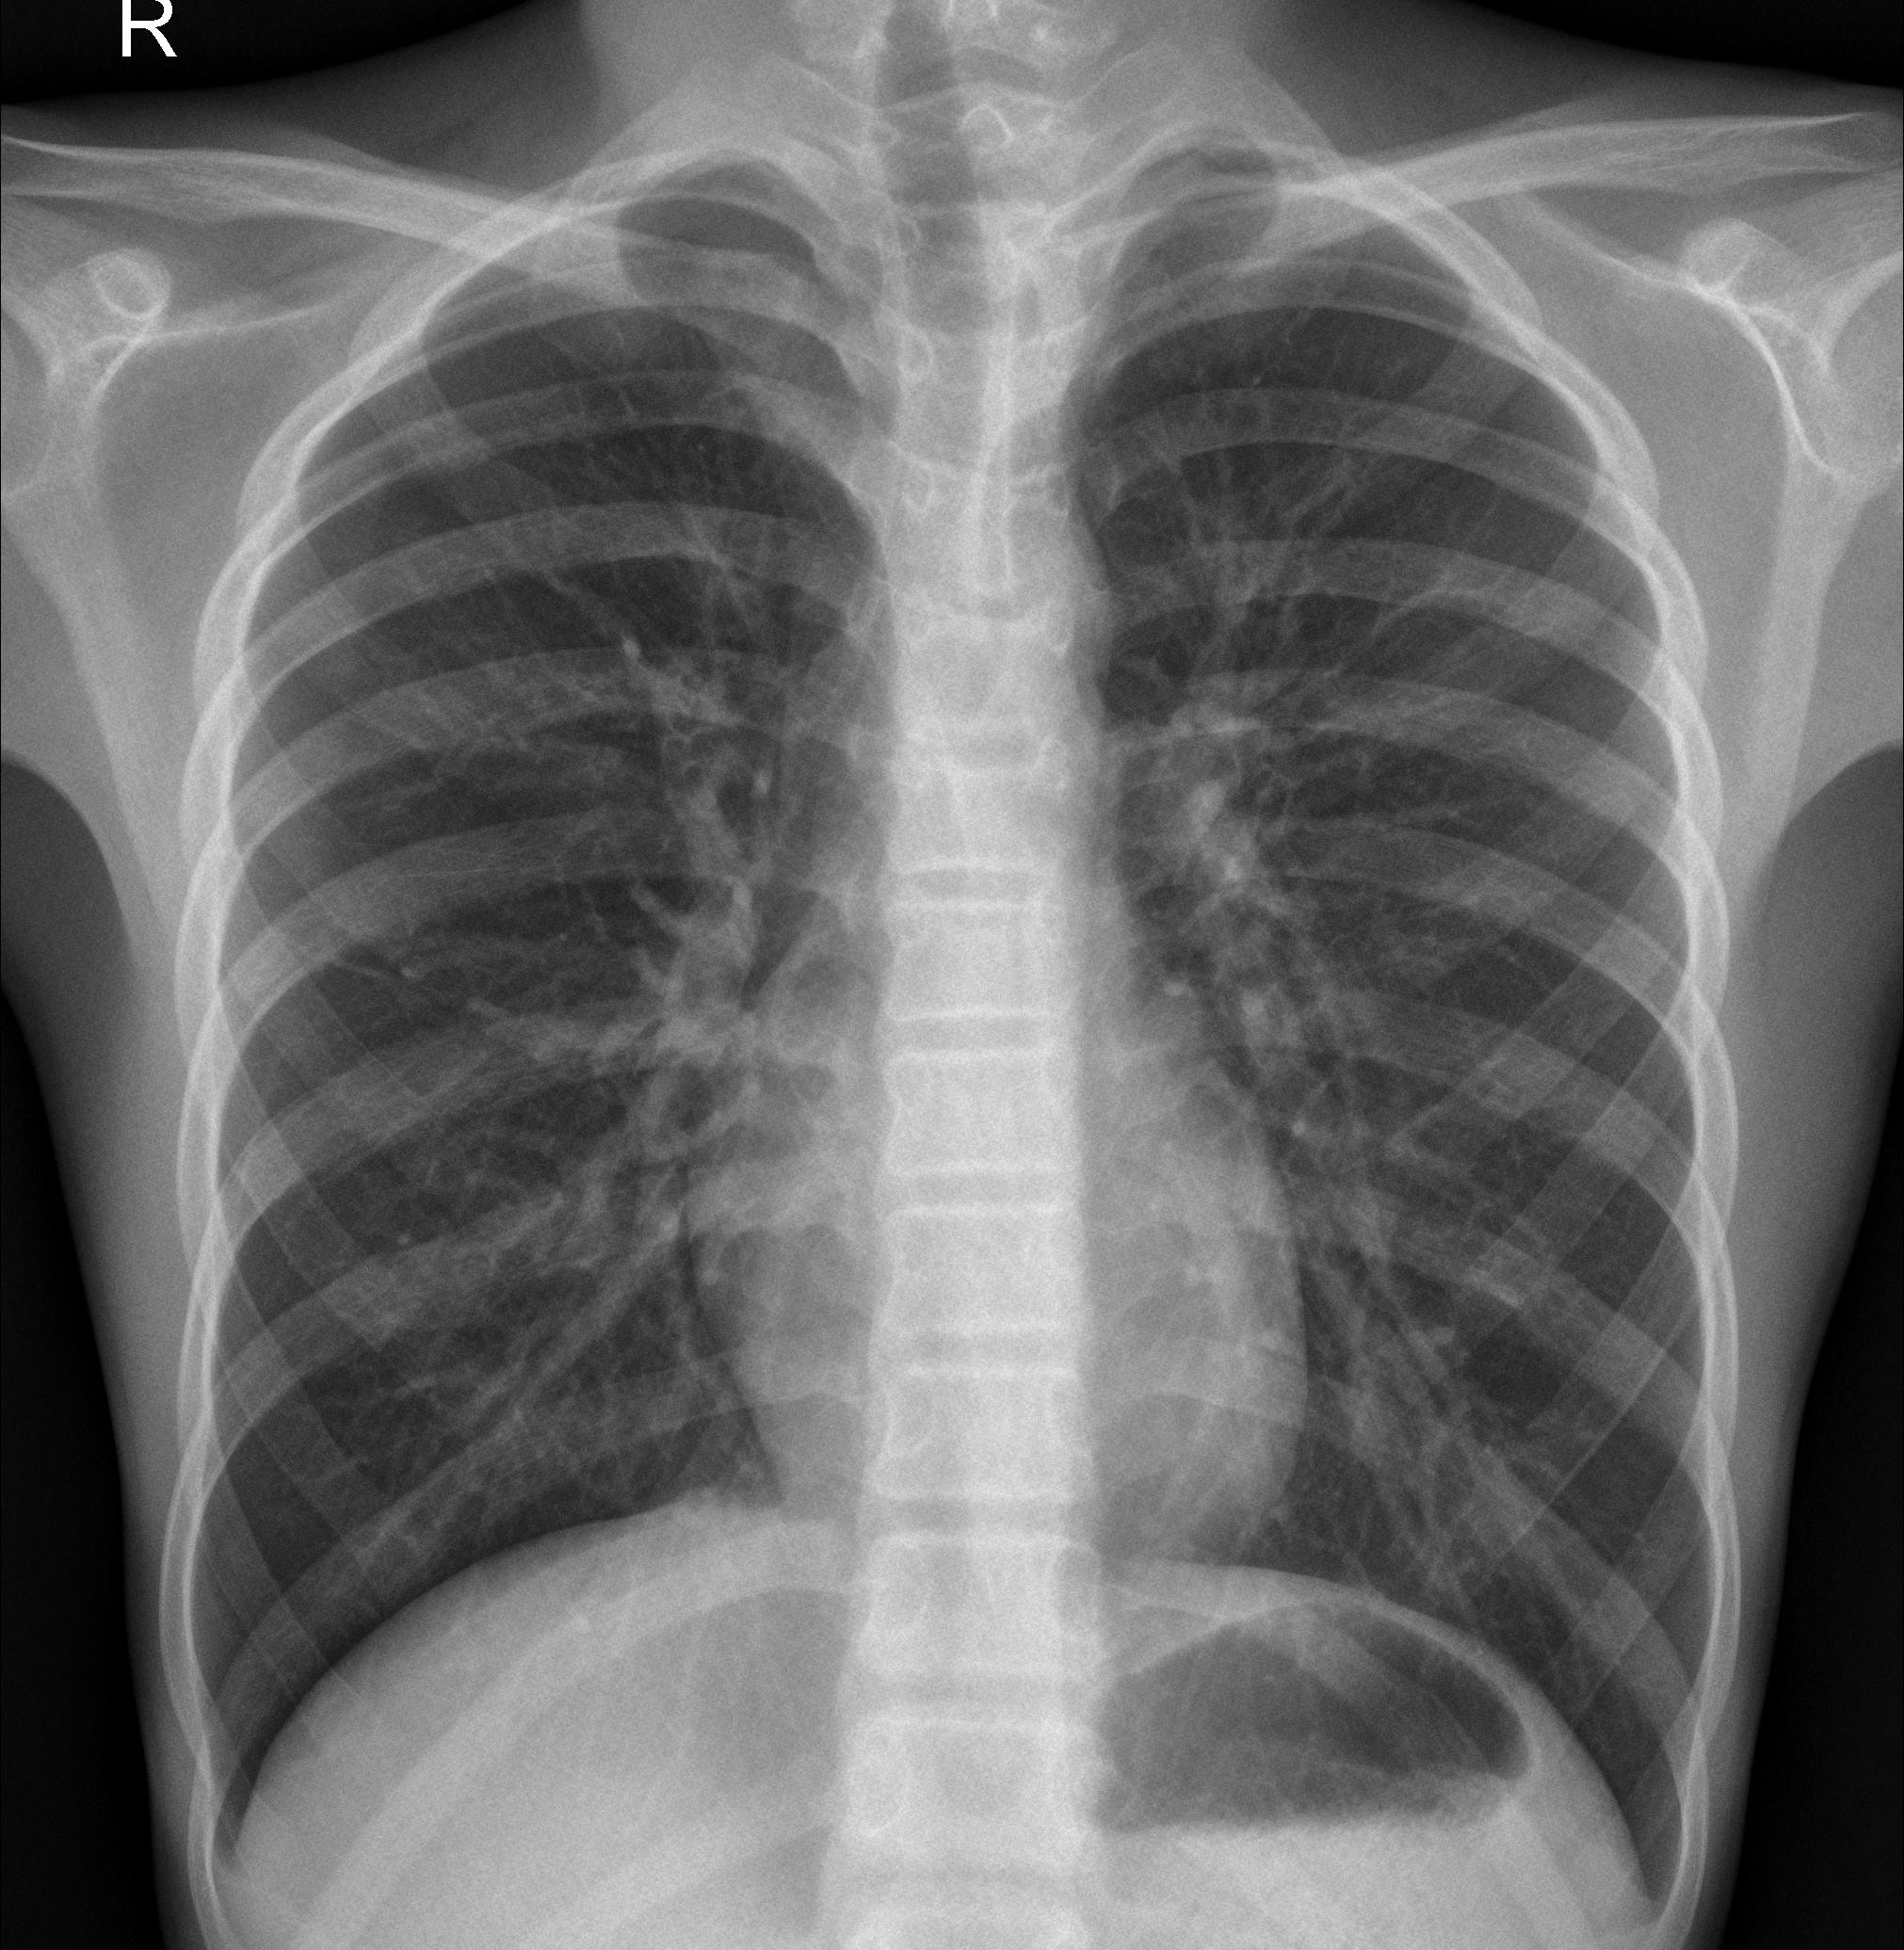


1/1 [==============================] - 0s 204ms/step
../data/data_sample/chest_xray/NORMAL/IM-0041-0001.jpeg
../output/gradcam/xception_model/NORMAL/IM-0041-0001.jpeg
[[ 3.83190117e+01  2.45632553e+01 -7.93997574e+00 -3.28409119e+01
  -3.78769379e+01 -4.55484772e+01 -2.06125278e+01 -1.20291891e+01
   1.02711735e+01 -1.10294886e+01  4.59817505e+01  2.06079350e+01
   2.48587666e+01 -2.43523598e+01 -9.67395973e+00 -8.48648834e+01
   2.24730492e+01  1.68884888e+01 -2.27956028e+01 -1.17395582e+01
  -2.63802567e+01 -2.74638500e+01 -4.33991699e+01 -4.08911285e+01
  -7.96331930e+00 -2.14442749e+01  2.95609169e+01  9.67439079e+00
   2.03550673e+00 -1.64306660e+01  4.15911150e+00  5.22544785e+01
   2.68219528e+01  2.51749096e+01  4.73435669e+01  7.06263828e+00
   7.91123199e+00 -1.28911819e+01  8.41984844e+00  8.68975353e+00
   4.86448708e+01 -9.87639904e-01  2.64266586e+00 -3.47897568e+01
  -1.83979988e+01 -3.43722038e+01  4.53321609e+01  3.47688484e+01
   4.95713294e-01 -1.77563896e+01  3.457

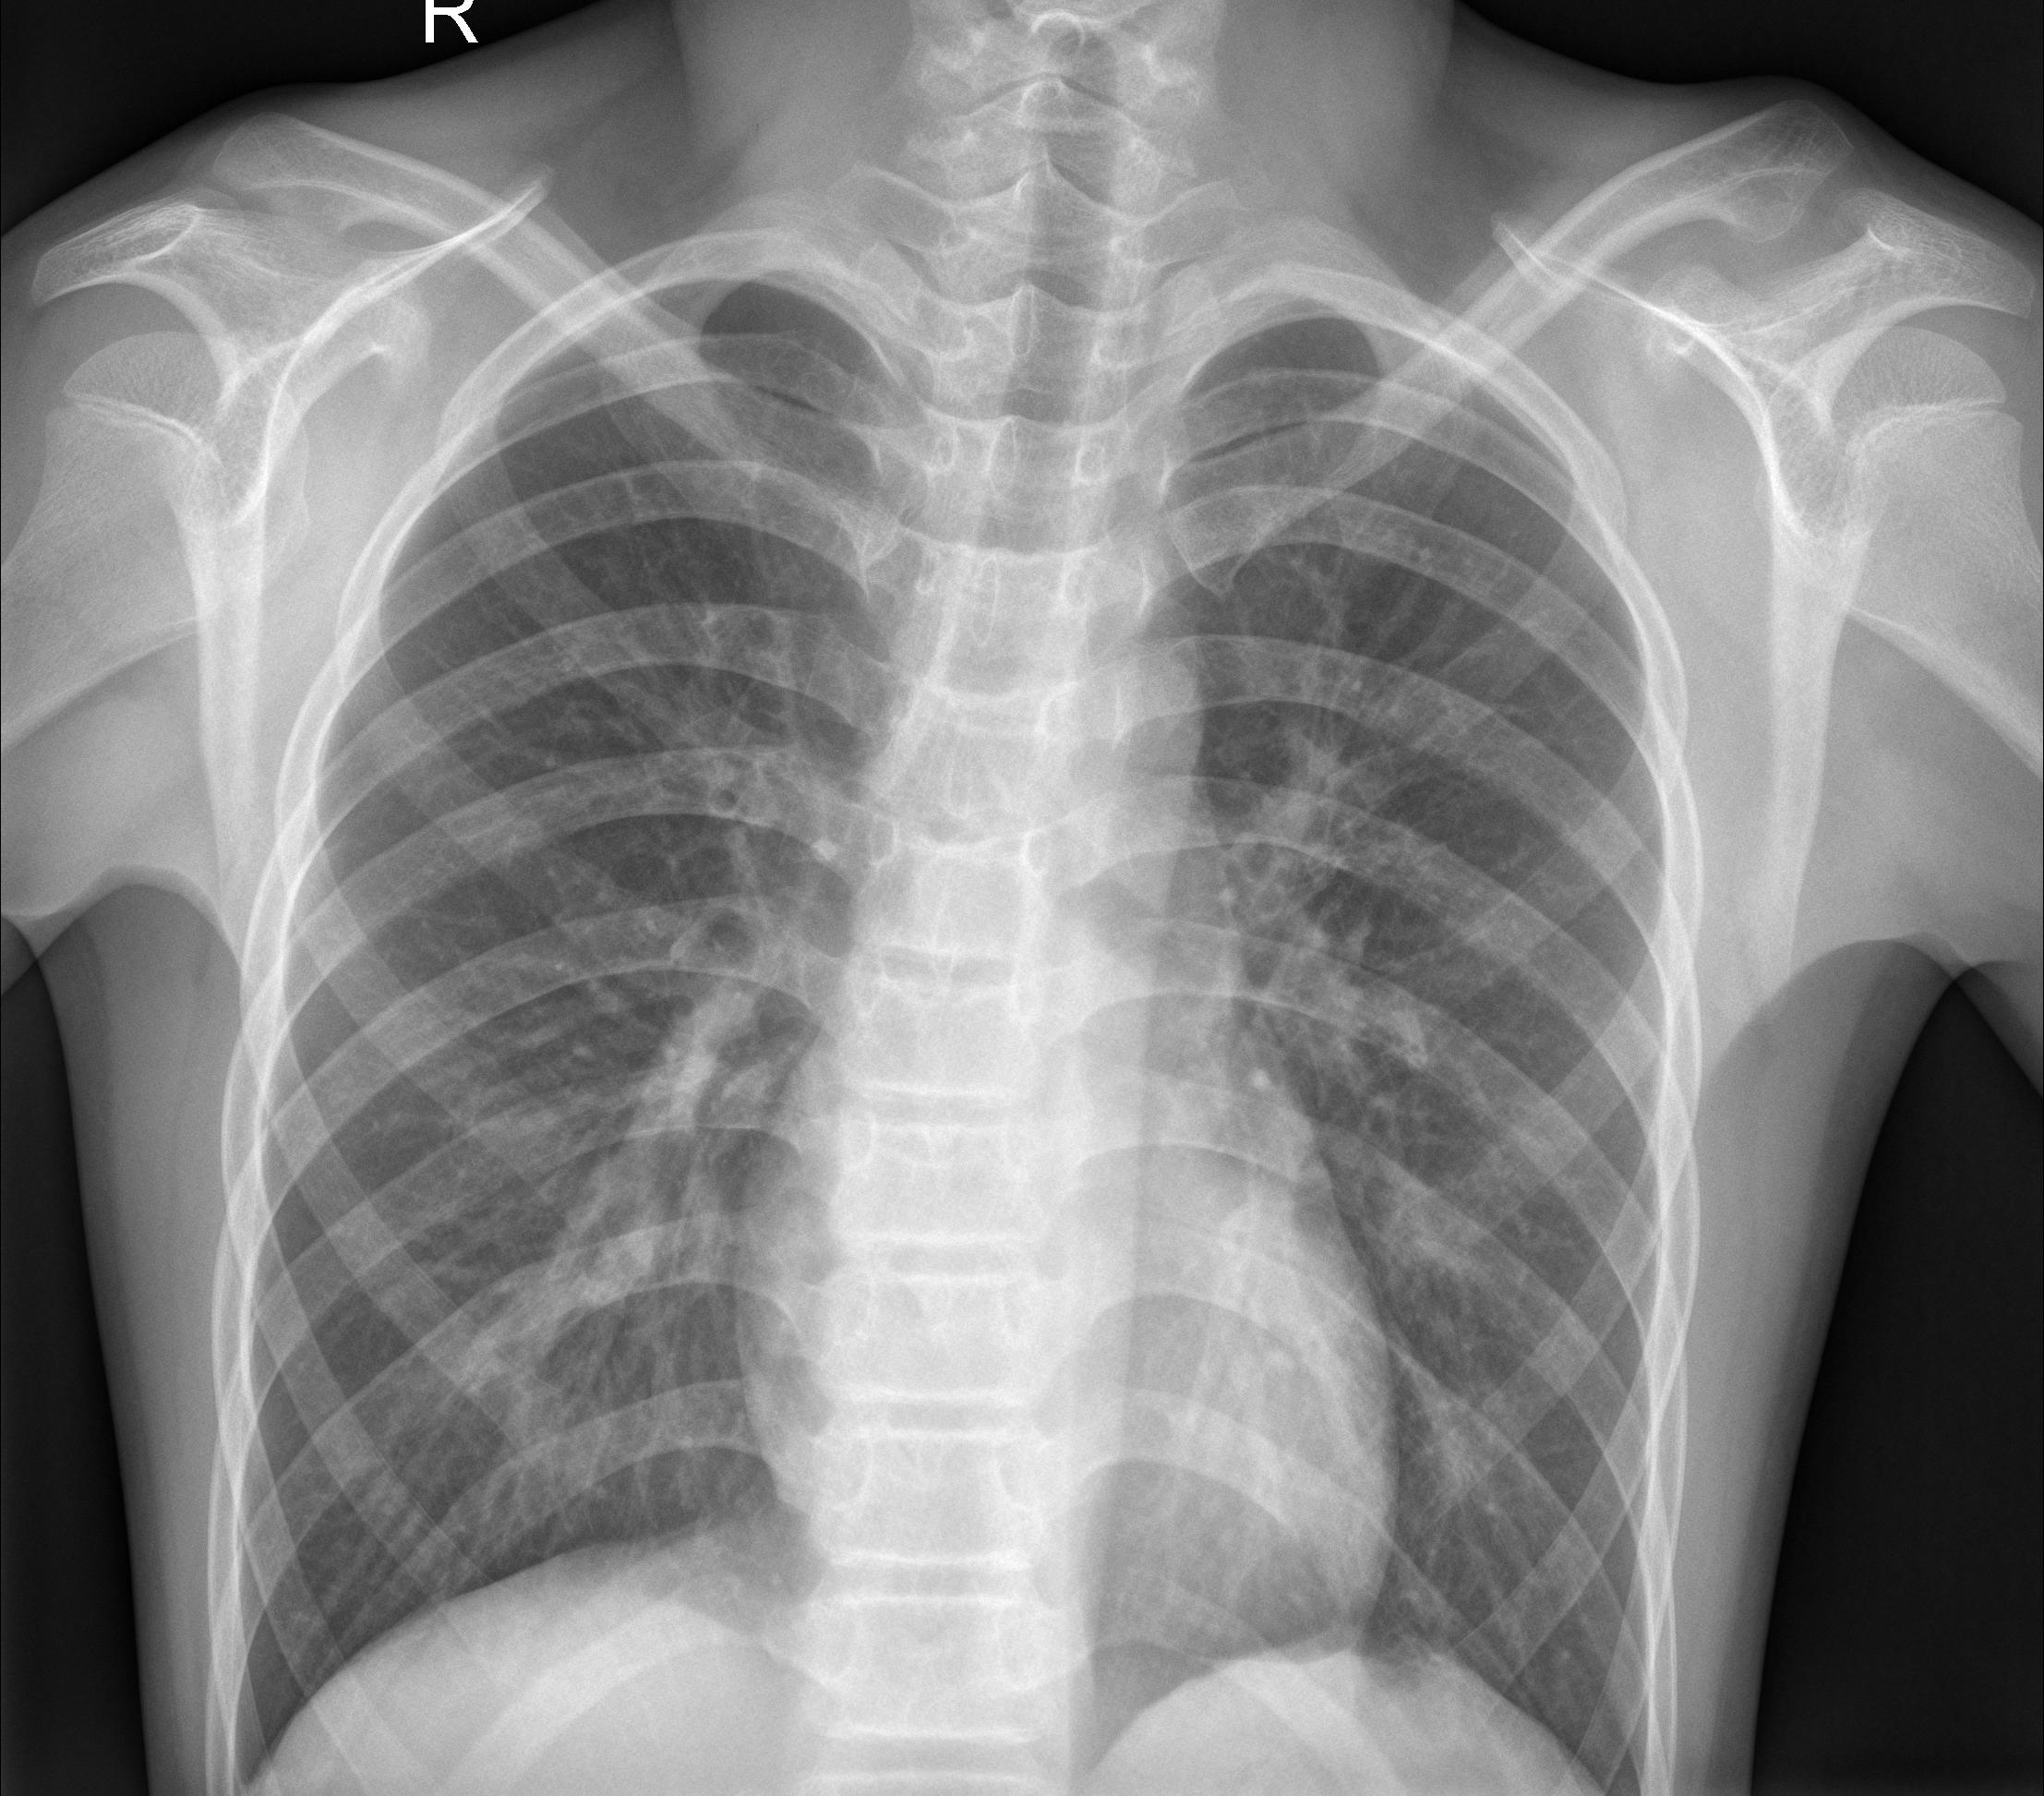


1/1 [==============================] - 0s 203ms/step
../data/data_sample/chest_xray/NORMAL/IM-0011-0001-0002.jpeg
../output/gradcam/xception_model/NORMAL/IM-0011-0001-0002.jpeg
[[ 2.88550320e+01  1.80202637e+01 -2.81620274e+01 -4.67723083e+01
  -3.79479942e+01 -6.66038132e+01 -3.53157387e+01 -2.70399723e+01
  -1.60442371e+01 -2.24015083e+01  5.72678261e+01  2.02008476e+01
   2.70362797e+01 -4.45894279e+01 -2.03525562e+01 -1.60405060e+02
   3.64166260e+01  1.98533859e+01 -5.01381264e+01 -1.68764496e+01
  -2.07666893e+01 -5.45755196e+01 -6.83303909e+01 -6.50737152e+01
  -2.58777294e+01 -4.74039688e+01  2.62478886e+01  5.55491734e+00
  -7.30854464e+00 -3.84763222e+01  5.67485523e+00  7.04497070e+01
   4.61293182e+01  4.47804413e+01  9.18248672e+01  9.34113598e+00
   2.44474335e+01 -4.08389931e+01 -2.22333641e+01  1.46625919e+01
   7.39100571e+01 -3.37429166e-01  8.20080280e+00 -6.72407150e+01
  -4.03749619e+01 -2.87097340e+01  7.21614914e+01  5.34348183e+01
   2.34432030e+01 -2.45265636e

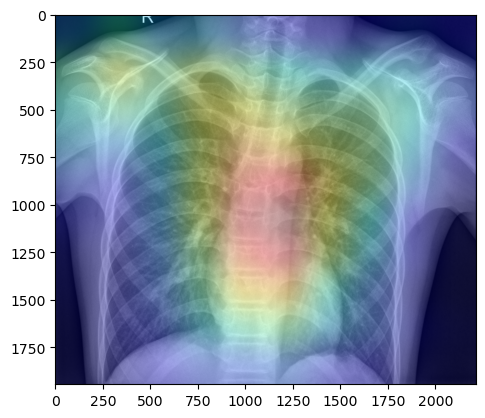

In [121]:
scan_label('N') # Normal

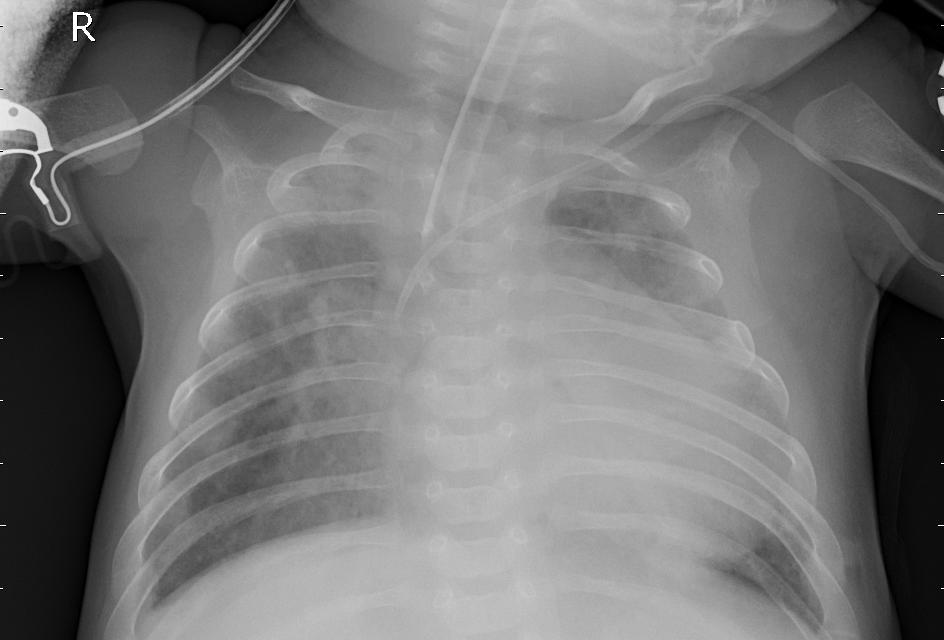

C:\Users\Giacomo Da Re\AppData\Local\Temp\ipykernel_32280\3427993503.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  jet = cm.get_cmap("jet")


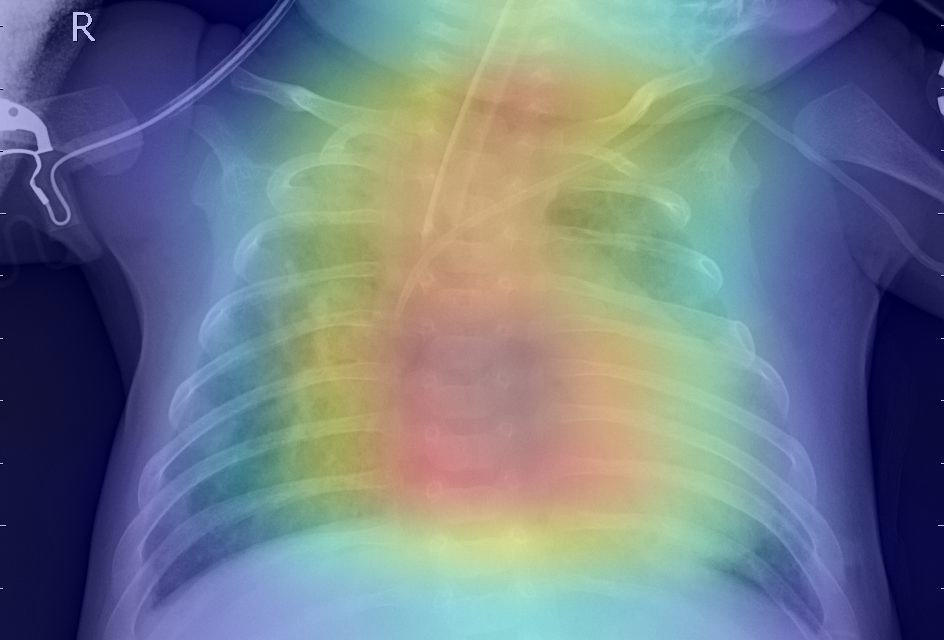


1/1 [==============================] - 0s 246ms/step
../data/data_sample/chest_xray/PNEUMONIA/person1_virus_6.jpeg
../output/gradcam/xception_model/PNEUMONIA/person1_virus_6.jpeg
[[-3.55283761e+00 -2.56914368e+01 -1.58088570e+01 -4.22126846e+01
  -4.87979546e+01 -1.24729073e+02 -8.07003250e+01  2.18172474e+01
  -1.85907125e+00 -2.81889362e+01  3.98254089e+01  9.87332821e+00
   2.03412113e+01 -5.80597534e+01 -1.29781036e+01 -1.62644669e+02
   3.01739311e+01  4.67982559e+01 -8.90670242e+01 -1.61602993e+01
   1.34644041e+01 -5.43881493e+01 -5.84551201e+01 -4.14017181e+01
  -2.17169666e+01 -7.44509506e+01 -1.78422241e+01 -1.82355804e+01
  -2.53946996e+00 -6.27283134e+01 -4.58511925e+00  3.93258476e+01
   3.73247185e+01  5.38900948e+00  1.19450264e+02 -1.71351776e+01
   2.91278610e+01 -6.20586967e+01 -5.23020554e+01  9.95555210e+00
   1.83671150e+01 -2.88967781e+01  4.72642362e-01 -8.28649368e+01
  -7.37979584e+01  1.47191372e+01  2.56090565e+01  5.50554323e+00
   2.74446926e+01 -7.7568368

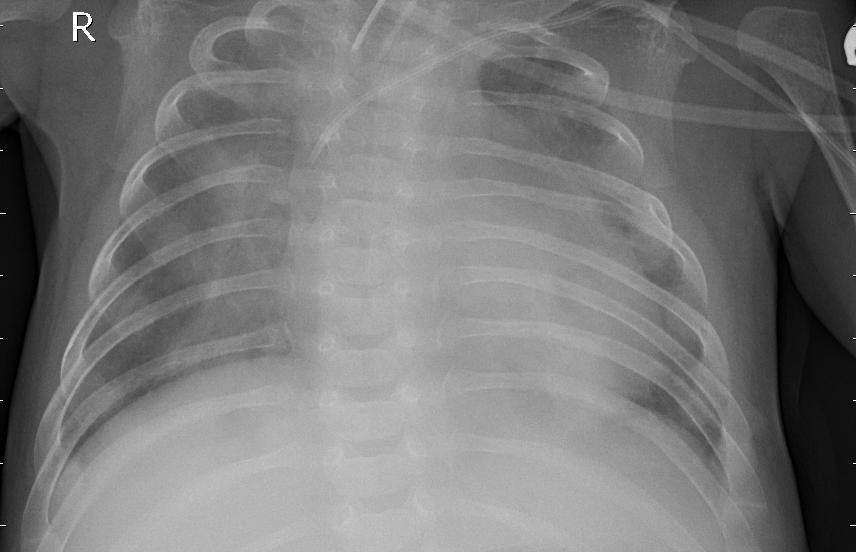


1/1 [==============================] - 0s 228ms/step
../data/data_sample/chest_xray/PNEUMONIA/person1_virus_9.jpeg
../output/gradcam/xception_model/PNEUMONIA/person1_virus_9.jpeg
[[ 5.12807417e+00 -1.91268024e+01 -1.97371044e+01 -3.76187401e+01
  -4.40565872e+01 -1.05992599e+02 -6.74100800e+01  1.67179871e+01
  -8.62450218e+00 -7.40141773e+00  3.91548119e+01  9.46488857e+00
   1.63386116e+01 -5.32956429e+01 -4.49866295e+00 -1.63309845e+02
   2.09578514e+01  5.90519562e+01 -7.38359604e+01 -1.16615124e+01
   1.37191267e+01 -6.21251907e+01 -6.67755508e+01 -2.72994442e+01
  -1.64600487e+01 -8.11529999e+01 -3.96331215e+01 -3.73368607e+01
  -7.90447760e+00 -5.94278870e+01 -1.67934341e+01  4.12643089e+01
   3.90735092e+01  2.26812124e+00  1.16691246e+02 -2.97197971e+01
   2.34412193e+01 -6.32291794e+01 -3.90460396e+01  1.78899918e+01
   1.50833626e+01 -2.45242729e+01  7.01708317e+00 -8.86867523e+01
  -8.43553085e+01  4.20872021e+00  3.36547546e+01 -9.42627907e+00
   2.21193619e+01 -1.9389106

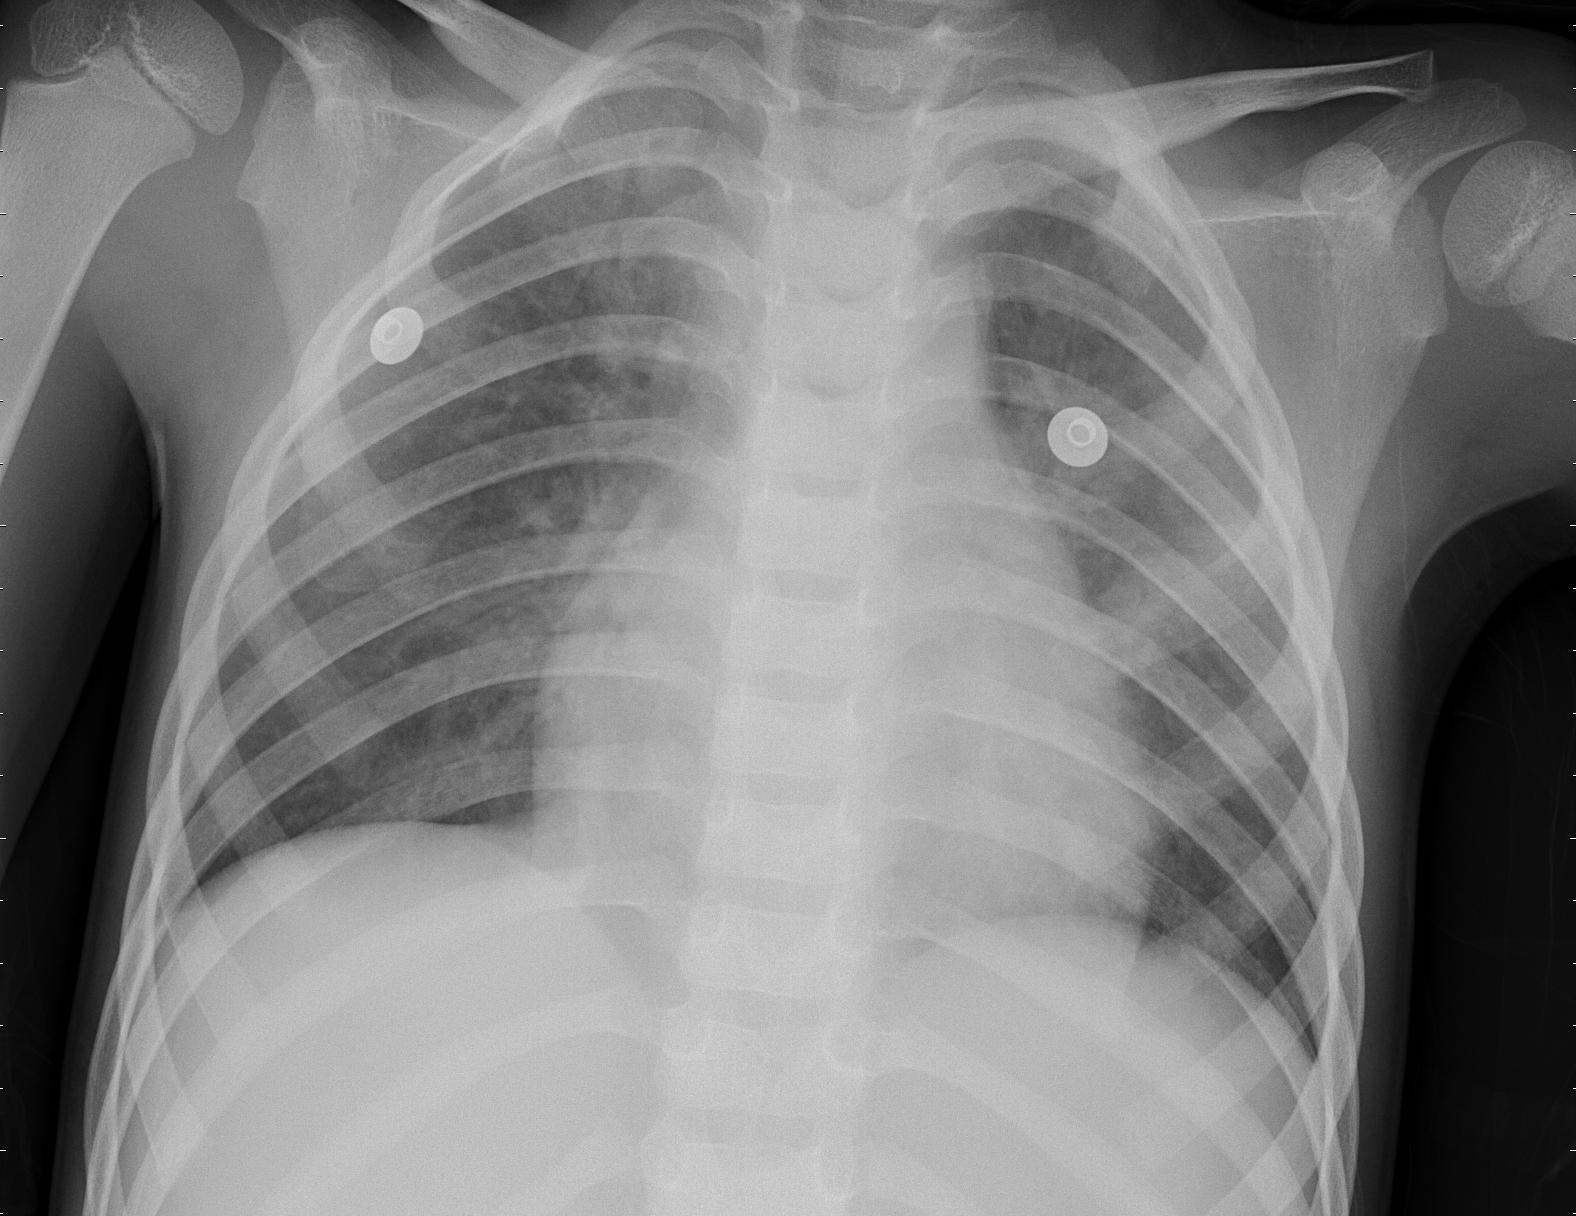

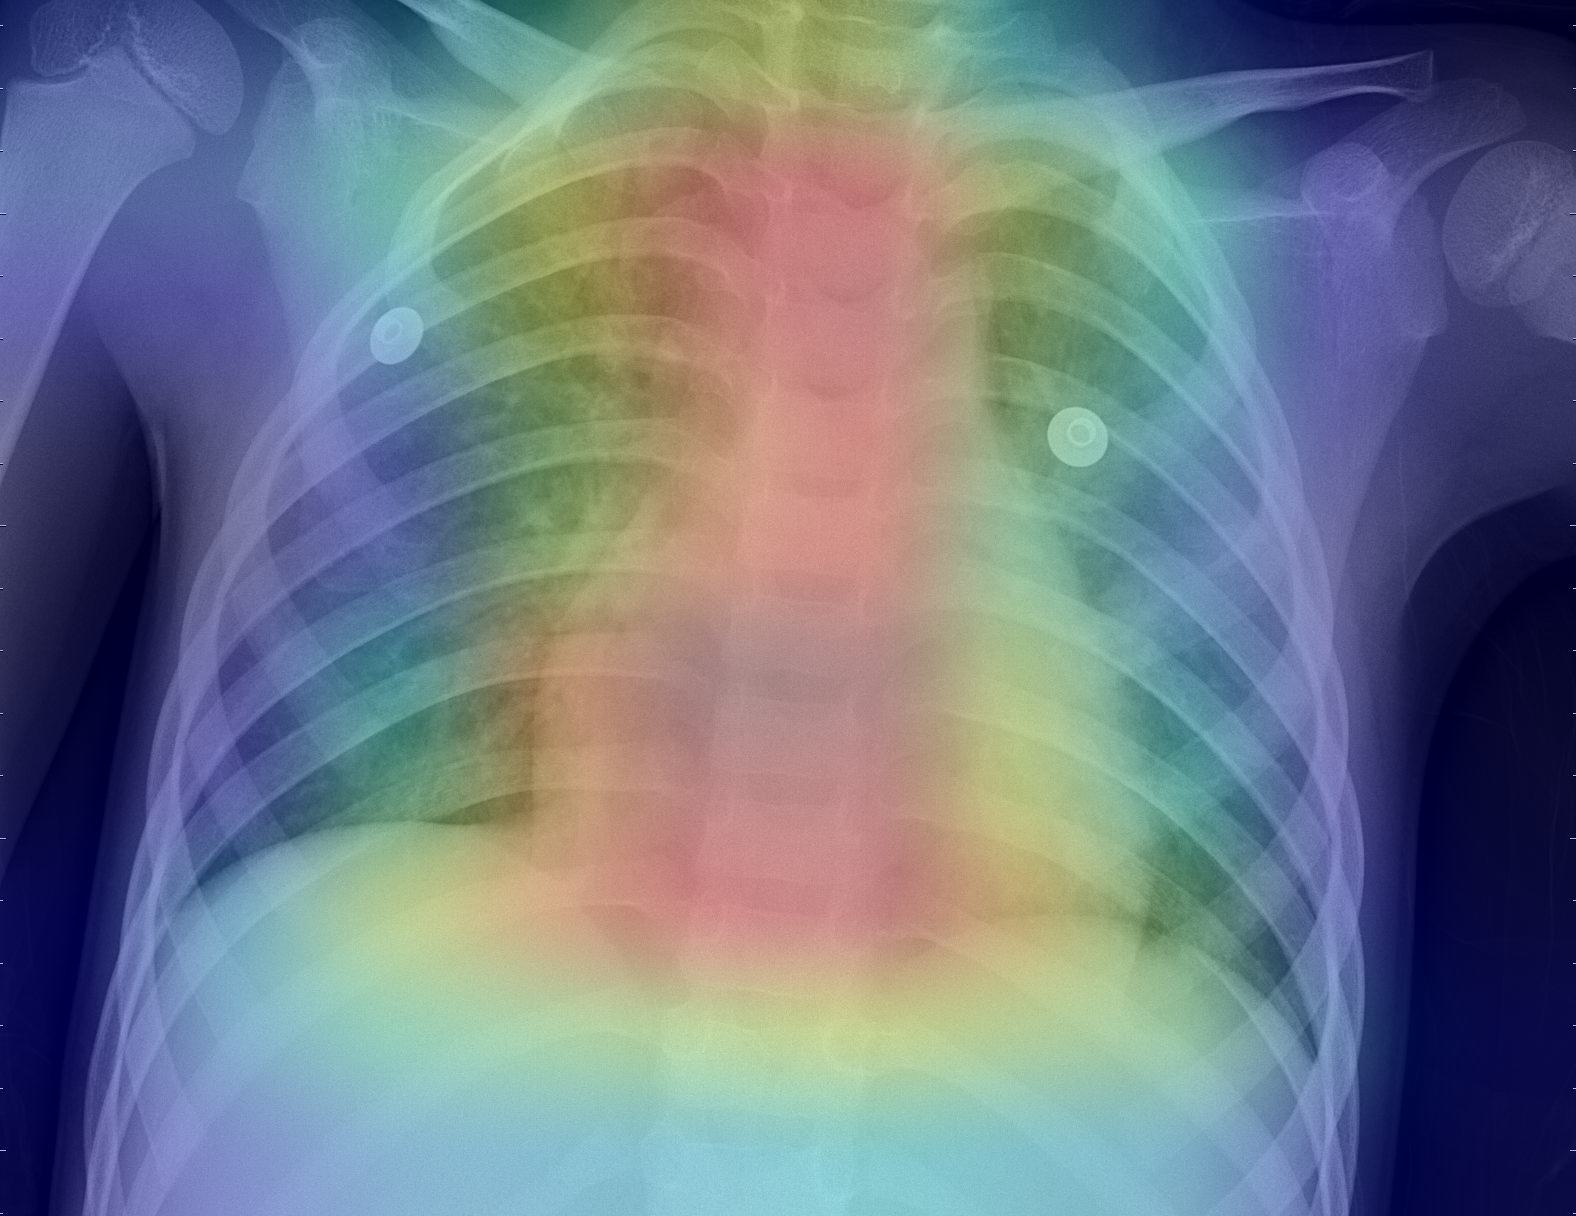


1/1 [==============================] - 0s 223ms/step
../data/data_sample/chest_xray/PNEUMONIA/person30_virus_69.jpeg
../output/gradcam/xception_model/PNEUMONIA/person30_virus_69.jpeg
[[ 1.86988316e+01  2.01663852e+00 -1.69672451e+01 -4.34260178e+01
  -5.46975937e+01 -9.98184891e+01 -5.73075485e+01 -9.85711932e-01
  -7.18297243e+00 -2.05013227e+00  5.67268753e+01  1.29913816e+01
   2.66538544e+01 -4.37540131e+01 -1.58123970e+01 -1.83500717e+02
   2.11649780e+01  4.00392380e+01 -6.03020287e+01 -1.12306938e+01
   1.52738943e+01 -7.87725449e+01 -6.78986435e+01 -3.93777504e+01
  -2.18498268e+01 -7.06240692e+01 -1.12494526e+01 -1.60477829e+01
  -4.99899340e+00 -5.19182777e+01 -7.03505135e+00  6.25283775e+01
   4.64557762e+01  2.48589535e+01  1.12423645e+02 -6.24547815e+00
   2.98526440e+01 -5.76622887e+01 -3.42603302e+01  1.11545095e+01
   3.53046036e+01 -2.64975071e+01  7.17136335e+00 -8.91181717e+01
  -6.26937370e+01 -8.18399048e+00  4.55754929e+01  3.08424592e+00
   2.37900028e+01 -8.914

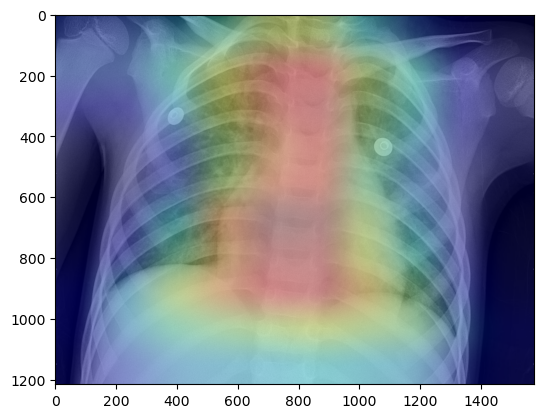

In [122]:
scan_label('P') # Pneumonia